In [17]:
import pandas as pd
import numpy as np
import random

infile = "results.pkl"
outfile = "perfChanges.plk"
samples = 10000
CIsmall = 100 - 99 # 99% conf
CImed = 100 - 95 # 95% conf
CIlarge = 100 - 10 # 90% conf
df_results = pd.read_pickle(infile)

In [18]:
#workloads = df_results.workload.unique()
#for workload in workloads:
#    print(workload)
changes = df_results.loc[(df_results['platform'] == 'google'),'change'].to_numpy()
medPerfChange = np.median(changes)
print(f"    Median Perf Change is {medPerfChange}%.")

manySamples = random.choices(changes, k=samples)
manySamples.sort()

small = int((samples * CIsmall) / 100 / 2)
if small == 0:
    small  = 1
medium = int((samples * CImed) / 100 / 2)
large = int((samples * CIlarge) / 100 / 2)

minSmall = manySamples[small-1]
#minSmall = (minSmall - 1)
maxSmall = manySamples[samples-small-1]
#maxSmall = (maxSmall - 1)

minMedium = manySamples[medium-1]
#minMedium = (minMedium - 1)
maxMedium = manySamples[samples-medium-1]
#maxMedium = (maxMedium - 1)

minLarge = manySamples[large-1]
#minLarge = (minLarge - 1)
maxLarge = manySamples[samples-large-1]
#maxLarge = (maxLarge - 1)

print(f"    Found conf. intervals ([{minSmall}, {maxSmall}],[{minMedium}, {maxMedium}],[{minLarge}, {maxLarge}]).")

    Median Perf Change is 1.092726483689244%.
    Found conf. intervals ([0.8050541516245487, 1.471264367816092],[0.8696275071633238, 1.3614931237721022],[1.0633608815426998, 1.105726872246696]).


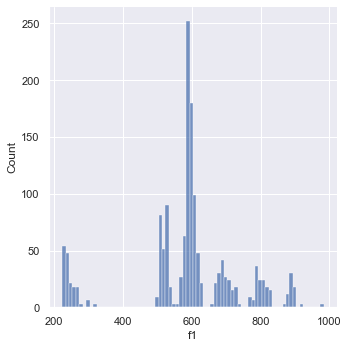

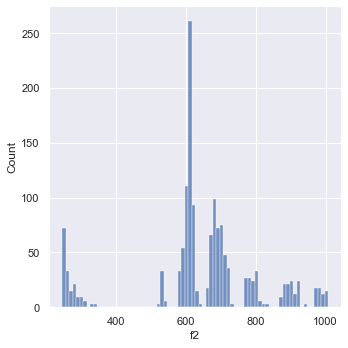

In [19]:
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

g = sns.displot(
    df_results, x="f1", binwidth=10,
)
#g.ax.set_xlim(0,800)

g = sns.displot(
    df_results, x="f2", binwidth=10,
)
#g.ax.set_xlim(0,800)


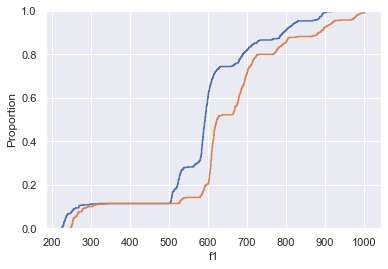

In [20]:
g = sns.ecdfplot(
    df_results, x="f1",
)

g = sns.ecdfplot(
    df_results, x="f2",
)